<a href="https://colab.research.google.com/github/matheuslopes99/matheuslopes99/blob/main/CIFAR10_85accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
transform_to_tensor_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]
)
transform_to_tensor_test = transforms.Compose([
    transforms.ToTensor()]
)

tensor_train_cifar10 = datasets.CIFAR10(root='/content/drive/MyDrive/Workspace/Cifar10DatasetNormalized', train=True, download=False, transform=transform_to_tensor_train)
tensor_test_cifar10 = datasets.CIFAR10(root='/content/drive/MyDrive/Workspace/Cifar10DatasetNormalized', train=False, download=False, transform=transform_to_tensor_test)


In [ ]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Descobrindo a média e o desvio padrão para normalizar os canais RGB

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_train_cifar10], dim=3)
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [ ]:
transformed_cifar10_train = datasets.CIFAR10(root='/content/drive/MyDrive/Workspace/Cifar10DatasetNormalized', train=True, download=False,
                                       transform=transforms.Compose([
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomCrop(32, padding=4),
                                          transforms.ToTensor(),
                                          transforms.RandomRotation(15),
                                          transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
                                       ]))
transformed_cifar10_test = datasets.CIFAR10(root='/content/drive/MyDrive/Workspace/Cifar10DatasetNormalized', train=False, download=False,
                                       transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
                                       ]))

In [ ]:
batch_size = 128
train_loader = DataLoader(transformed_cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(transformed_cifar10_test, batch_size=batch_size*2, pin_memory=True)

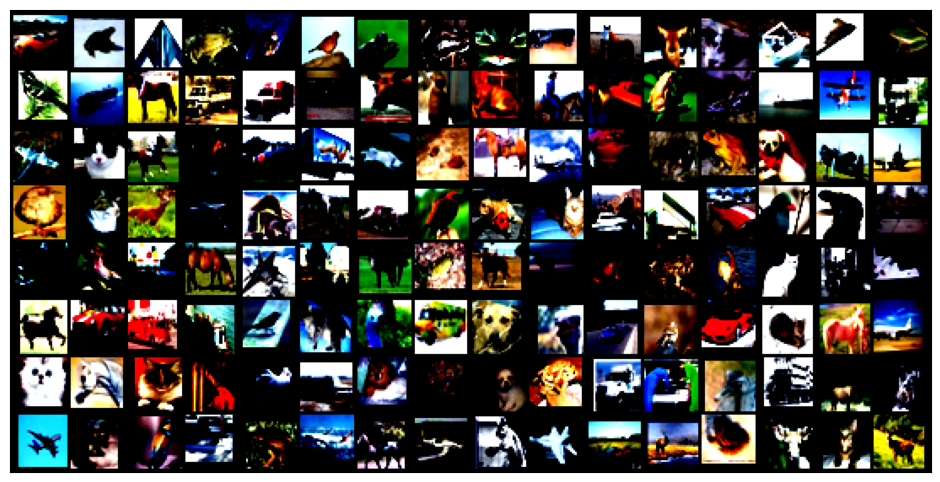

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

Rede neural

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                     # Generate predictions
        loss = F.cross_entropy(out, labels)    # Calculate loss
        acc = self.accuracy(out, labels)       # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ConvModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def validation_step(self, batch):
        images, labels = batch
        out = self(images)                     # Generate predictions
        loss = F.cross_entropy(out, labels)    # Calculate loss
        acc = self.accuracy(out, labels)       # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

  def forward(self, x):
    return self.network(x)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Rodando na ", device)

Rodando na  cuda


In [ ]:
model = to_device(ConvModel(), device)
model

ConvModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

Treinamento

In [ ]:
# def train(model, dataloader, lossfunc, optimizer):
#   model.train()
#   cumloss = 0.0
#   for imgs, labels in dataloader:
#     imgs, labels = imgs.to(device), labels.to(device)
#     pred = model(imgs)
#     loss = lossfunc(pred, labels)
#     #zera os gradientes
#     optimizer.zero_grad()
#     #computa os gradientes
#     loss.backward()
#     #anda na direção que minimiza o erro local
#     optimizer.step()
#     cumloss+=loss.item()
#     return cumloss/len(dataloader)

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in test_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD, weight_decay=0.0):
  history = []
  optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, test_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
# epochs = 31
# train_losses = []
# test_losses = []
# for t in range(epochs):
#   train_loss = train(model, train_loader, lossfunc, optimizer)
#   train_losses.append(train_loss)
#   if t%10==0:
#     print('Epoch: ', t, ' Train Loss: ', train_loss)
#   test_loss = validate(model, test_loader, lossfunc)
#   test_losses.append(test_loss)

Epoch:  0  Train Loss:  0.023489283055675273
Epoch:  10  Train Loss:  0.023482524618810535
Epoch:  20  Train Loss:  0.02348859456120705
Epoch:  30  Train Loss:  0.02349972238346022


In [ ]:
# def make_confusion_matrix(model, loader, n_classes):
#   confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
#   with torch.no_grad():
#     for i, (imgs, labels) in enumerate(loader):
#       imgs = imgs.to(device)
#       labels = labels.to(device)
#       outputs = model(imgs)
#       _,predicted = torch.max(outputs, 1)
#       for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1),
#                       torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
#           confusion_matrix[t, p]+=1
#   return confusion_matrix

# def evaluate_accuracy(model, dataloader, classes, verbose=True):
#   correct_pred = {classname: 0 for classname in classes}
#   total_pred = {classname: 0 for classname in classes}

#   confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
#   if verbose:
#     total_correct = 0.0
#     total_prediction = 0.0
#     for i, classname in enumerate(classes):
#       correct_count = confusion_matrix[i][i].item()
#       class_pred = torch.sum(confusion_matrix[i]).item()

#       total_correct+=correct_count
#       total_prediction+=class_pred

#       accuracy = 100*float(correct_count) / class_pred
#       print("Accuracy for class ", classname, " is: ", accuracy)
#   print("Global accuracy is: ", 100*total_correct/total_prediction)
#   return confusion_matrix

In [ ]:
# confusion_matrix = evaluate_accuracy(model, test_loader, list(cifar10_labels.values()))

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def reset_model_parameters(model):
    for module in model.modules():
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()
reset_model_parameters(model)

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(test_loader, device)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
weight_decay = 0.0001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func, weight_decay=weight_decay)
def reset_model_parameters(model):
    for module in model.modules():
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()

Epoch [0], train_loss: 1.7155, val_loss: 1.3507, val_acc: 0.4981
Epoch [1], train_loss: 1.2308, val_loss: 1.0236, val_acc: 0.6321
Epoch [2], train_loss: 0.9941, val_loss: 0.8996, val_acc: 0.6780
Epoch [3], train_loss: 0.8393, val_loss: 0.7858, val_acc: 0.7268
Epoch [4], train_loss: 0.7490, val_loss: 0.6715, val_acc: 0.7708
Epoch [5], train_loss: 0.6808, val_loss: 0.6868, val_acc: 0.7578
Epoch [6], train_loss: 0.6211, val_loss: 0.6037, val_acc: 0.7937
Epoch [7], train_loss: 0.5764, val_loss: 0.5832, val_acc: 0.8055
Epoch [8], train_loss: 0.5359, val_loss: 0.5903, val_acc: 0.8006
Epoch [9], train_loss: 0.5118, val_loss: 0.5233, val_acc: 0.8209


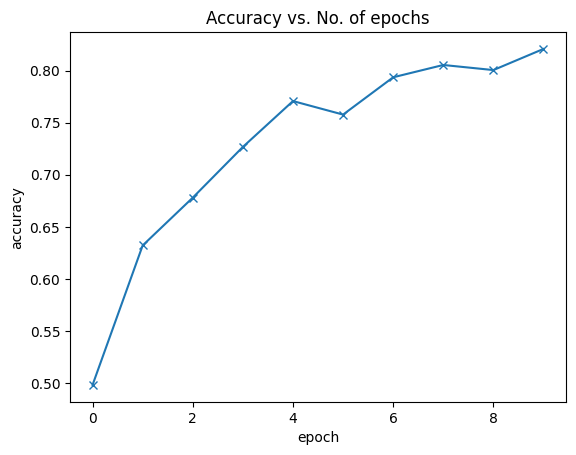

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)